In [1]:
import gymnasium as gym
import gym_donkeycar

import os
from ruamel.yaml import YAML
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

# Set the environment variable to suppress TensorFlow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from networks.utils import to_np, load_config

# custom classes and functions
from networks.blocks import ConvBlock, CategoricalStraightThrough
from networks.rssm import RSSM
from networks.mlp import MLP
from networks.categorical_vae import CategoricalVAE
from networks.actor_critic import ContinuousActorCritic
from preprocessing import grayscale_transform as transform

torch.cuda.empty_cache()
%matplotlib inline

/home/till/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
device = torch.device("cpu")

## Init the environment

## Playground  \~( ˘▾˘~)

## AC training loop for Cartpole

In [90]:
# # environment hyperparams
# n_envs = 1
# n_updates = 1000
# n_steps_per_update = 128
# 
# agent = ContinuousActorCritic(
#      n_features=3, 
#      n_actions=1,
#      n_envs=n_envs,
#      gamma=0.99,
#      lam=0.95,
#      entropy_coeff=0.01, # 0.01
#      critic_lr=0.005,
#      actor_lr=0.001
# ).to(device)

In [91]:
# # create a wrapper environment to save episode returns and episode lengths
# 
# envs = gym.vector.make("Pendulum-v1", num_envs=n_envs, max_episode_steps=200)
# envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs*n_updates)
# 
# critic_losses = []
# actor_losses = []
# entropies = []
# 
# for sample_phase in tqdm(range(n_updates)):
#     
#     # we don't have to reset the envs, they just continue playing
#     # until the episode is over and then reset automatically
# 
#     ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
#     ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
#     ep_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
#     ep_entropies = torch.zeros(n_steps_per_update, n_envs, device=device)
#     ep_masks = torch.zeros(n_steps_per_update, n_envs, device=device)
# 
#     if sample_phase == 0:
#         obs, info = envs_wrapper.reset(seed=0)
#         obs = torch.Tensor(obs)
# 
#     for step in range(n_steps_per_update):
#         
#         # get action and value
#         action, log_prob, actor_entropy = agent.get_action(obs)
#         value_pred = agent.critic(obs)
# 
#         # env step
#         obs, reward, terminated, truncated, infos = envs_wrapper.step(to_np(action))
#         obs = torch.Tensor(obs)
# 
#         ep_value_preds[step] = value_pred.squeeze()
#         ep_rewards[step] = torch.tensor(reward, device=device)
#         ep_log_probs[step] = log_prob.squeeze()
#         ep_entropies[step] = actor_entropy.squeeze()
# 
#         # add a mask (for the return calculation later);
#         # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
#         ep_masks[step] = torch.Tensor([not term for term in terminated], device=device)
# 
#     # calculate the losses for actor and critic
#     critic_loss, actor_loss = agent.get_loss(ep_rewards, ep_log_probs, ep_value_preds, ep_entropies, ep_masks)
# 
#     # update the actor and critic networks
#     agent.update_parameters(critic_loss, actor_loss)
# 
#     # log the losses and entropy
#     critic_losses.append(to_np(critic_loss))
#     actor_losses.append(to_np(actor_loss))
#     entropies.append(to_np(ep_entropies.mean()))

In [92]:
# """ Plot the results """
# 
# rolling_length = max(1, int(len(envs_wrapper.return_queue) / 20))
# 
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
# fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")
# 
# # Episode return
# axs[0, 0].set_title("Episode Returns")
# episode_returns_moving_average = np.convolve(np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
# axs[0, 0].set_xlabel("Number of episodes")
# 
# # Entropy
# axs[1, 0].set_title("Entropy")
# entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
# axs[1, 0].plot(entropy_moving_average)
# axs[1, 0].set_xlabel("Number of updates")
# 
# # Critic loss
# axs[0, 1].set_title("Critic Loss")
# critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[0, 1].plot(critic_losses_moving_average)
# axs[0, 1].set_xlabel("Number of updates")
# 
# # Actor loss
# axs[1, 1].set_title("Actor Loss")
# actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[1, 1].plot(actor_losses_moving_average)
# axs[1, 1].set_xlabel("Number of updates")
# 
# plt.tight_layout()
# plt.show()

## Showcase

In [93]:
# envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")
# 
# obs, info = envs.reset(seed=0)
# obs = torch.Tensor(obs)
# 
# for step in range(n_steps_per_update):
#     
#     # get action and value
#     action, action_log_probs, actor_entropy = agent.get_action(obs)
#     value = agent.critic(obs)
#     
#     # env step
#     obs, rewards, terminated, truncated, infos = envs.step(to_np(action))
#     obs = torch.Tensor(obs)
# 
# envs.close()

## Try discrete variant

In [33]:
idx_to_action = [-2, -1, -0.3, -0.1, 0, 0.1, 0.3, 1, 2]
len(idx_to_action)

9

In [94]:
class A2C(nn.Module):
    """
    (Synchronous) Advantage Actor-Critic agent class

    Args:
        n_features: The number of features of the input state.
        n_actions: The number of actions the agent can take.
        device: The device to run the computations on (running on a GPU might be quicker for larger Neural Nets,
                for this code CPU is totally fine).
        critic_lr: The learning rate for the critic network (should usually be larger than the actor_lr).
        actor_lr: The learning rate for the actor network.
        n_envs: The number of environments that run in parallel (on multiple CPUs) to collect experiences.
    """

    def __init__(
        self,
        n_features: int,
        n_actions: int,
        device: torch.device,
        critic_lr: float,
        actor_lr: float,
        n_envs: int,
        gamma: float,
        lam: float,
        ent_coef: float,
        
    ) -> None:
        """Initializes the actor and critic networks and their respective optimizers."""
        super().__init__()
        self.device = device
        self.n_envs = n_envs
        self.gamma = gamma
        self.lam = lam
        self.ent_coef = ent_coef

        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(
                32, n_actions
            ),  # estimate action logits (will be fed into a softmax later)
        ]

        # define actor and critic networks
        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)

        # define optimizers for actor and critic
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)

    def forward(self, x: np.ndarray) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the networks.

        Args:
            x: A batched vector of states.

        Returns:
            state_values: A tensor with the state values, with shape [n_envs,].
            action_logits_vec: A tensor with the action logits, with shape [n_envs, n_actions].
        """
        x = torch.Tensor(x).to(self.device)
        state_values = self.critic(x)  # shape: [n_envs,]
        action_logits_vec = self.actor(x)  # shape: [n_envs, n_actions]
        return (state_values, action_logits_vec)

    def select_action(
        self, x: np.ndarray
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of the chosen actions and the log-probs of those actions.

        Args:
            x: A batched vector of states.

        Returns:
            actions: A tensor with the actions, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions, with shape [n_steps_per_update, n_envs].
            state_values: A tensor with the state values, with shape [n_steps_per_update, n_envs].
        """
        state_values, action_logits = self.forward(x)
        action_pd = torch.distributions.Categorical(
            logits=action_logits
        )  # implicitly uses softmax
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return (actions, action_log_probs, state_values, entropy)

    def get_losses(
        self,
        rewards: torch.Tensor,
        action_log_probs: torch.Tensor,
        value_preds: torch.Tensor,
        entropy: torch.Tensor,
        masks: torch.Tensor,
        gamma: float,
        lam: float,
        ent_coef: float,
        device: torch.device,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Computes the loss of a minibatch (transitions collected in one sampling phase) for actor and critic
        using Generalized Advantage Estimation (GAE) to compute the advantages (https://arxiv.org/abs/1506.02438).

        Args:
            rewards: A tensor with the rewards for each time step in the episode, with shape [n_steps_per_update, n_envs].
            action_log_probs: A tensor with the log-probs of the actions taken at each time step in the episode, with shape [n_steps_per_update, n_envs].
            value_preds: A tensor with the state value predictions for each time step in the episode, with shape [n_steps_per_update, n_envs].
            masks: A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
            gamma: The discount factor.
            lam: The GAE hyperparameter. (lam=1 corresponds to Monte-Carlo sampling with high variance and no bias,
                                          and lam=0 corresponds to normal TD-Learning that has a low variance but is biased
                                          because the estimates are generated by a Neural Net).
            device: The device to run the computations on (e.g. CPU or GPU).

        Returns:
            critic_loss: The critic loss for the minibatch.
            actor_loss: The actor loss for the minibatch.
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)

        # compute the advantages using GAE
        gae = 0.0
        for t in reversed(range(T - 1)):
            td_error = (
                rewards[t] + self.gamma * masks[t] * value_preds[t + 1] - value_preds[t]
            )
            gae = td_error + self.gamma * self.lam * masks[t] * gae
            advantages[t] = gae

        # calculate the loss of the minibatch for actor and critic
        critic_loss = advantages.pow(2).mean()

        # give a bonus for higher entropy to encourage exploration
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean() - self.ent_coef * entropy.mean()
        )
        return (critic_loss, actor_loss)

    def update_parameters(
        self, critic_loss: torch.Tensor, actor_loss: torch.Tensor
    ) -> None:
        """
        Updates the parameters of the actor and critic networks.

        Args:
            critic_loss: The critic loss.
            actor_loss: The actor loss.
        """
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [105]:
# environment hyperparams
n_envs = 1
n_updates = 10
n_steps_per_update = 128

# agent hyperparams
gamma = 0.999
lam = 0.95  # hyperparameter for GAE
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 0.001
critic_lr = 0.005

agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs, gamma, lam, ent_coef)

In [149]:
def train(n_envs, n_updates, n_steps_per_update):
    # create a wrapper environment to save episode returns and episode lengths
    envs = gym.vector.make("Pendulum-v1", num_envs=n_envs, max_episode_steps=200)
    envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs * n_updates)

    critic_losses = []
    actor_losses = []
    entropies = []

    # use tqdm to get a progress bar for training
    for sample_phase in tqdm(range(n_updates)):
        # we don't have to reset the envs, they just continue playing
        # until the episode is over and then reset automatically

        # reset lists that collect experiences of an episode (sample phase)
        ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
        ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
        masks = torch.zeros(n_steps_per_update, n_envs, device=device)

        # at the start of training reset all envs to get an initial state
        if sample_phase == 0:
            states, info = envs_wrapper.reset(seed=42)

        # play n steps in our parallel environments to collect data
        for step in range(n_steps_per_update):
            # select an action A_{t} using S_{t} as input for the agent
            actions, action_log_probs, state_value_preds, entropy = agent.select_action(
                states
            )

            # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
            continuous_action = []
            for idx in actions:
                continuous_action.append([idx_to_action[idx.item()]])

            states, rewards, terminated, truncated, infos = envs_wrapper.step(
                np.array(continuous_action)
            )

            ep_value_preds[step] = torch.squeeze(state_value_preds)
            ep_rewards[step] = torch.tensor(rewards, device=device)
            ep_action_log_probs[step] = action_log_probs

            # add a mask (for the return calculation later);
            # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
            masks[step] = torch.tensor([not term for term in terminated])

        # calculate the losses for actor and critic
        critic_loss, actor_loss = agent.get_losses(
            ep_rewards,
            ep_action_log_probs,
            ep_value_preds,
            entropy,
            masks,
            gamma,
            lam,
            ent_coef,
            device,
        )

        # update the actor and critic networks
        agent.update_parameters(critic_loss, actor_loss)

        # log the losses and entropy
        critic_losses.append(critic_loss.detach().cpu().numpy())
        actor_losses.append(actor_loss.detach().cpu().numpy())
        entropies.append(entropy.detach().mean().cpu().numpy())
    
    return envs_wrapper.return_queue, critic_losses, actor_losses, entropies

In [97]:
# """ Plot the results """
# 
# rolling_length = max(1, int(len(envs_wrapper.return_queue) / 20))
# 
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
# fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")
# 
# # Episode return
# axs[0, 0].set_title("Episode Returns")
# episode_returns_moving_average = np.convolve(np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
# axs[0, 0].set_xlabel("Number of episodes")
# 
# # Entropy
# axs[1, 0].set_title("Entropy")
# entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
# axs[1, 0].plot(entropy_moving_average)
# axs[1, 0].set_xlabel("Number of updates")
# 
# # Critic loss
# axs[0, 1].set_title("Critic Loss")
# critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[0, 1].plot(critic_losses_moving_average)
# axs[0, 1].set_xlabel("Number of updates")
# 
# # Actor loss
# axs[1, 1].set_title("Actor Loss")
# actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
# axs[1, 1].plot(actor_losses_moving_average)
# axs[1, 1].set_xlabel("Number of updates")
# 
# plt.tight_layout()
# plt.show()

In [98]:
# envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")
# 
# obs, info = envs.reset(seed=0)
# obs = torch.Tensor(obs)
# 
# for step in range(n_steps_per_update):
#     
#     # get action and value
#     action, state_value, action_log_probs, actor_entropy = agent.select_action(obs)
#     continuous_action = []
#     for idx in actions:
#         continuous_action.append([idx_to_action[idx.item()]])
#     #print(continuous_action)
#     # env step
#     obs, rewards, terminated, truncated, infos = envs.step(continuous_action)
#     obs = torch.Tensor(obs)
# 
# envs.close()

In [138]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective

In [114]:
space  = [
    Real(0, 1, name="gamma"),
    Real(0, 1, name="lam"),
    Real(10**-10, 10**4, "log-uniform", name="ent_coef"),
    Real(10**-5, 10**0, "log-uniform", name="actor_lr"),
    Real(10**-5, 10**0, "log-uniform", name="critic_lr"),
]

In [82]:
# # environment hyperparams
# n_envs = 1
# n_updates = 1000
# n_steps_per_update = 128
# 
# # agent hyperparams
# gamma = 0.999
# lam = 0.95  # hyperparameter for GAE
# ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
# actor_lr = 0.001
# critic_lr = 0.005
# 
# agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs)

In [133]:
@use_named_args(space)
def objective(**params):
    """  The objective we want to MINIMIZE """
    
    # for a neural net
    # model.set_params(**params)
    # return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error"))
    
    print(params)
    # result = 0
    # for x in params.values():
    #     result -= x
    # return result
    
    # environment hyperparams
    n_envs = 1
    n_updates = 1000
    n_steps_per_update = 128

    # agent hyperparams
    gamma = params["gamma"]
    lam = params["lam"]
    ent_coef = params["ent_coef"]
    actor_lr = params["actor_lr"]
    critic_lr = params["critic_lr"]

    agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs, gamma, lam, ent_coef)

    return_queue, critic_losses, actor_losses, entropies = train(
        n_envs, n_updates, n_steps_per_update) # we want to maximize this
    
    result = - sum(return_queue) # we want to minimize this
    # print("result:", result, "(we want to minimize this)")
    return result

In [135]:
from skopt import gp_minimize
gp_result = gp_minimize(
    objective, 
    space, 
    n_calls=20, 
    random_state=0)

print("Best score:", gp_result.fun)

{'gamma': 0.5928446182250184, 'lam': 0.8442657485810175, 'ent_coef': 102.62156813526508, 'actor_lr': 0.17228945369609433, 'critic_lr': 0.013116515715358098}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.67it/s]

summed episode return: -718188.0765380859 (we want to maximize this)
{'gamma': 0.38438170729269994, 'lam': 0.29753460654447234, 'ent_coef': 6.222740385086999e-10, 'actor_lr': 0.00023082427114609125, 'critic_lr': 0.0024452630570839917}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.72it/s]

summed episode return: -598341.0277404785 (we want to maximize this)
{'gamma': 0.8121687287754934, 'lam': 0.47997717237505744, 'ent_coef': 3.154911240457583e-05, 'actor_lr': 0.15149343663386153, 'critic_lr': 0.0004863857046189474}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.73it/s]

summed episode return: -297317.27660512924 (we want to maximize this)
{'gamma': 0.6481718720511973, 'lam': 0.368241539840548, 'ent_coef': 2512.882751540135, 'actor_lr': 5.0321537523063144e-05, 'critic_lr': 0.22409712855921127}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.62it/s]

summed episode return: -202840.33783864975 (we want to maximize this)
{'gamma': 0.4736080452737106, 'lam': 0.8009107519796445, 'ent_coef': 0.0019350166830846048, 'actor_lr': 0.02479691484362036, 'critic_lr': 0.04010174523739503}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.59it/s]

summed episode return: -164367.17299199104 (we want to maximize this)
{'gamma': 0.5820197920751072, 'lam': 0.5373732294490108, 'ent_coef': 4.174637216759602, 'actor_lr': 3.3848391532325447e-05, 'critic_lr': 0.002333469328026273}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.29it/s]

summed episode return: -245996.93235492706 (we want to maximize this)
{'gamma': 0.18633234332676, 'lam': 0.7369181771289582, 'ent_coef': 1.0757341650799824e-07, 'actor_lr': 4.743412208473003e-05, 'critic_lr': 0.00041754668393896886}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.48it/s]

summed episode return: -154202.5685095787 (we want to maximize this)
{'gamma': 0.1496748671836832, 'lam': 0.2223213882515877, 'ent_coef': 2.5754061934024123e-05, 'actor_lr': 0.3258309822543486, 'critic_lr': 0.001777255838269662}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.55it/s]

summed episode return: -175265.74743938446 (we want to maximize this)
{'gamma': 0.6130634578841325, 'lam': 0.9023485831739845, 'ent_coef': 2.4542845023556715e-09, 'actor_lr': 0.7063912950459896, 'critic_lr': 0.018437421276495978}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.28it/s]

summed episode return: -239742.85047101974 (we want to maximize this)
{'gamma': 0.17090958513604518, 'lam': 0.35815216696952507, 'ent_coef': 3.2330020281650538, 'actor_lr': 0.010943426958445033, 'critic_lr': 0.0004219258607446576}



  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.24it/s]


summed episode return: -149150.3271856308 (we want to maximize this)
{'gamma': 0.1672601378166107, 'lam': 0.3138724833666794, 'ent_coef': 57.43277755731439, 'actor_lr': 0.29063377615604574, 'critic_lr': 0.00042294792874614137}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.22it/s]


summed episode return: -136061.46463942528 (we want to maximize this)
{'gamma': 0.14603617638802704, 'lam': 0.11485322831110875, 'ent_coef': 11.775331271990996, 'actor_lr': 0.09733412674775088, 'critic_lr': 0.0004288903856077381}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.34it/s]


summed episode return: -154183.888302207 (we want to maximize this)
{'gamma': 0.18132081813048445, 'lam': 0.5294409538262316, 'ent_coef': 11.15385035422555, 'actor_lr': 1.0, 'critic_lr': 0.00041899867421475555}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.17it/s]


summed episode return: -256358.40231847763 (we want to maximize this)
{'gamma': 0.5876781525900625, 'lam': 0.13577818316791443, 'ent_coef': 67.00190018870434, 'actor_lr': 0.23957365070089515, 'critic_lr': 0.0004235846401458186}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.39it/s]


summed episode return: -127429.40330088139 (we want to maximize this)
{'gamma': 0.6402189214627626, 'lam': 0.06311997964473752, 'ent_coef': 75.41791757827767, 'actor_lr': 0.20296809653208858, 'critic_lr': 0.00042414481746760646}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.49it/s]


summed episode return: -135851.16750121117 (we want to maximize this)
{'gamma': 0.6465868354757066, 'lam': 0.13968520609932397, 'ent_coef': 82.75653550681312, 'actor_lr': 0.2620750799627887, 'critic_lr': 0.00043644039962712947}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.33it/s]


summed episode return: -132263.15109348297 (we want to maximize this)
{'gamma': 0.0, 'lam': 0.8167437551331165, 'ent_coef': 7.824868194578102e-06, 'actor_lr': 1e-05, 'critic_lr': 0.0024713631385471255}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.52it/s]


summed episode return: -190280.13775968552 (we want to maximize this)
{'gamma': 0.0, 'lam': 0.05105944864572958, 'ent_coef': 0.00011651453878145112, 'actor_lr': 1.0, 'critic_lr': 0.010191428209543194}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.28it/s]


summed episode return: -134232.21553468704 (we want to maximize this)
{'gamma': 0.16915713854303663, 'lam': 0.20579904921064518, 'ent_coef': 86.70392387260326, 'actor_lr': 1.0, 'critic_lr': 0.0003070888353556237}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.55it/s]


summed episode return: -123381.98765408993 (we want to maximize this)
{'gamma': 0.0, 'lam': 0.9183513853903964, 'ent_coef': 2.277114499896753e-07, 'actor_lr': 1e-05, 'critic_lr': 3.382463823348019e-05}


  0%|                                                                                                  | 0/1000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.48it/s]


summed episode return: -122166.79256224632 (we want to maximize this)
Best score: 122166.79256224632


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

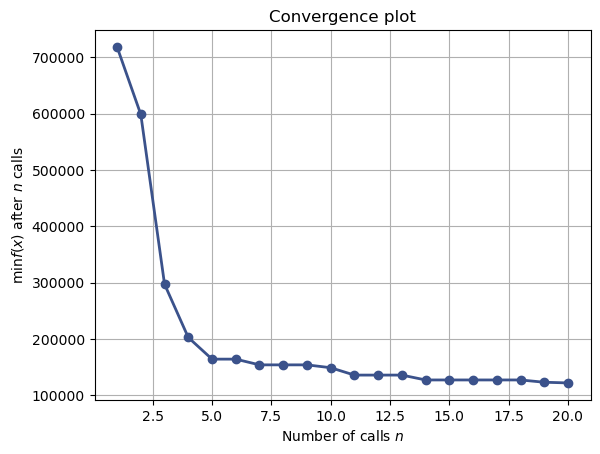

In [136]:
plot_convergence(gp_result)

array([[<AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='lam'>,
        <AxesSubplot:xlabel='lam', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='ent_coef'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='ent_coef', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='actor_lr'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='actor_lr', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='gamma', ylabel='critic_lr'>,
        <AxesSubplot:xlabel='lam'>, <AxesSubplot:xlabel='ent_coef'>,
        <AxesSubplot:xlabel='actor_lr'>,
        <AxesSubplot:xlabel='critic_lr', ylabel='Partial dependence'>]],
      dtype=object)

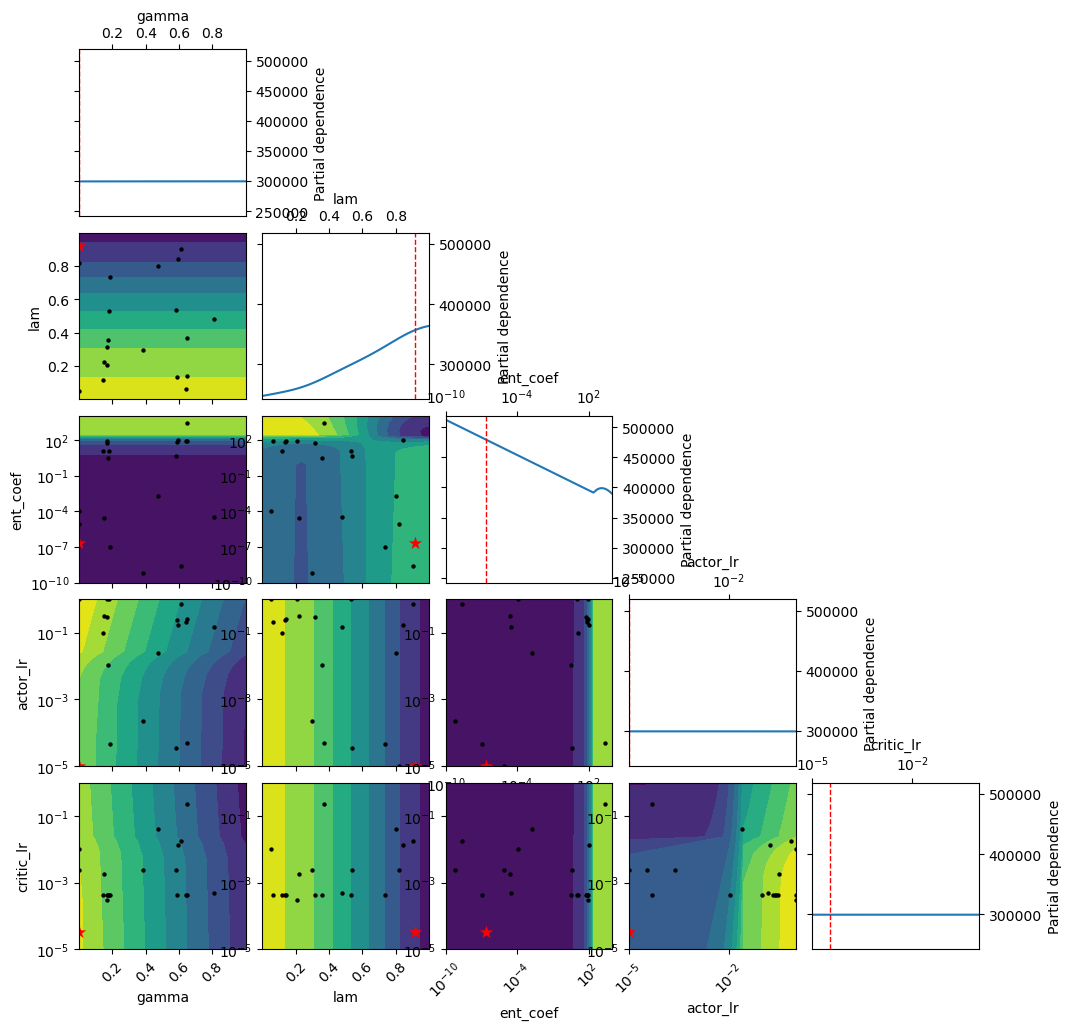

In [139]:
plot_objective(gp_result)

In [157]:
""" train an agent with the best params """

print("best parameters:", gp_result.x)

gamma, lam, ent_coef, actor_lr, critic_lr = gp_result.x
agent = A2C(3, 9, device, critic_lr, actor_lr, n_envs, gamma, lam, ent_coef)

# set longer training time
n_envs = 1
n_updates = 3000
n_steps_per_update = 128

return_queue, critic_losses, actor_losses, entropies = train(n_envs, n_updates, n_steps_per_update)

best parameters: [0.0, 0.9183513853903964, 2.277114499896753e-07, 1e-05, 3.382463823348019e-05]


  0%|                                                                                                  | 0/3000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|███████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:35<00:00, 19.29it/s]


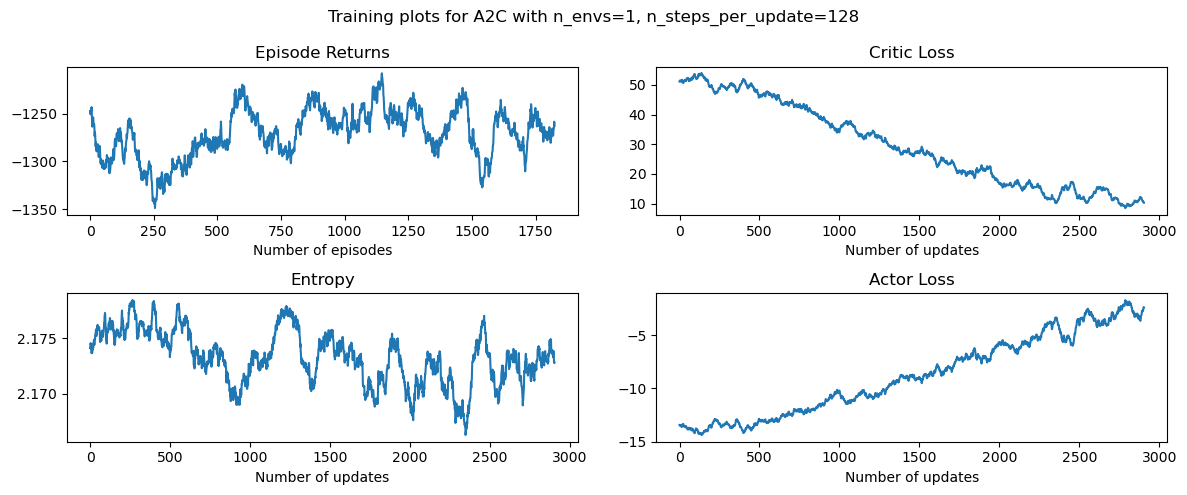

In [158]:
""" Plot the results """

rolling_length = max(1, int(len(return_queue) / 20))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")

# Episode return
axs[0, 0].set_title("Episode Returns")
episode_returns_moving_average = np.convolve(np.array(return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
axs[0, 0].set_xlabel("Number of episodes")

# Entropy
axs[1, 0].set_title("Entropy")
entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 0].plot(entropy_moving_average)
axs[1, 0].set_xlabel("Number of updates")

# Critic loss
axs[0, 1].set_title("Critic Loss")
critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 1].plot(critic_losses_moving_average)
axs[0, 1].set_xlabel("Number of updates")

# Actor loss
axs[1, 1].set_title("Actor Loss")
actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 1].plot(actor_losses_moving_average)
axs[1, 1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [162]:
envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")

obs, info = envs.reset(seed=0)
obs = torch.Tensor(obs)

for step in range(n_steps_per_update):
    
    # get action and value
    action, state_value, action_log_probs, actor_entropy = agent.select_action(obs)
    continuous_action = []
    for idx in actions:
        continuous_action.append([idx_to_action[idx.item()]])
    #print(continuous_action)
    # env step
    obs, rewards, terminated, truncated, infos = envs.step(continuous_action)
    obs = torch.Tensor(obs)

envs.close()

/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
